In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from fastFM import als
from scipy.sparse import csr_matrix

In [2]:
d = extract.get_data()
d = extract.clean_data(d)

/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


### Need to split d in to two chunks based on time (i.e. first 20 days, last 10 days). Then generate set of dprice data for each chunk separately.

In [3]:
d_state_features = extract.build_state_features(d, num_states = None)
d_other_features = extract.build_other_text_features(d)
d_t = pd.concat([d.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), d_state_features, d_other_features], axis = 1)
d_1 = d_t[d.tradedate < 20]
d_2 = d_t[d.tradedate >= 20]
d_t.head()

,tradeid,cusip,amount,price,yield,tradedate,name,coupon,maturity,issuesize,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype
0,317.0,45471AKG6,5000.0,99.507,4.037,2.0,indiana st fin auth-a,4.00,6694.0,88930000.0,...,0,0,0,0,0,0,0,0,0,1
1,318.0,45471AKG6,30000.0,99.410,4.045,2.0,indiana st fin auth-a,4.00,6694.0,88930000.0,...,0,0,0,0,0,0,0,0,0,1
2,319.0,45471AKG6,30000.0,99.290,4.054,2.0,indiana st fin auth-a,4.00,6694.0,88930000.0,...,0,0,0,0,0,0,0,0,0,0
3,333.0,45471AMY5,15000.0,103.145,3.717,2.0,in fin auth-major,4.25,6482.0,9520000.0,...,0,0,0,0,0,0,0,0,0,1
4,378.0,4550572N8,150000.0,114.082,2.060,2.0,in fin auth-ref-a,5.00,2953.0,22530000.0,...,0,0,0,0,0,0,0,0,1,1


In [4]:
#remove cusips from d_2 that don't appear in d_1
cusips_1 = d_1.cusip.unique()
I = d_2.cusip.apply(lambda x: x in cusips_1)
d_2_filtered = d_2.loc[I,:]
print(d_2_filtered.shape, d_2.shape)

((12489, 116), (15396, 116))


In [5]:
s_1 = extract.compile_price_change_data(d_1, tradetype_dict = {'purchase': 1, 'sell': 0})
s_2 = extract.compile_price_change_data(d_2_filtered, tradetype_dict = {'purchase': 1, 'sell': 0})

extract.compile_price_change_data: finished cusip 0 of 3537
extract.compile_price_change_data: finished cusip 1 of 3537
extract.compile_price_change_data: finished cusip 2 of 3537
extract.compile_price_change_data: finished cusip 3 of 3537
extract.compile_price_change_data: finished cusip 4 of 3537
extract.compile_price_change_data: finished cusip 5 of 3537
extract.compile_price_change_data: finished cusip 6 of 3537
extract.compile_price_change_data: finished cusip 7 of 3537
extract.compile_price_change_data: finished cusip 8 of 3537
extract.compile_price_change_data: finished cusip 9 of 3537
extract.compile_price_change_data: finished cusip 10 of 3537
extract.compile_price_change_data: finished cusip 11 of 3537
extract.compile_price_change_data: finished cusip 12 of 3537
extract.compile_price_change_data: finished cusip 13 of 3537
extract.compile_price_change_data: finished cusip 14 of 3537
extract.compile_price_change_data: finished cusip 15 of 3537
extract.compile_price_change_data:

In [6]:
s_1.to_csv("./data/first_20_days_price_change_data.csv")
s_2.to_csv("./data/last_10_days_price_change_data.csv")
s_1 = pd.read_csv("./data/first_20_days_price_change_data.csv")
s_2 = pd.read_csv("./data/last_10_days_price_change_data.csv")
s_1.pop('Unnamed: 0')
s_2.pop('Unnamed: 0')
s_1 = s_1[s_1.holdtime < 7]
s_2 = s_2[s_2.holdtime < 7]

In [7]:
s_2.head()

,tradeid,cusip,amount,price,yield,tradedate,name,coupon,maturity,issuesize,...,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype,dprice,holdtime,d_index
0,67692.0,977123ZW1,15000.0,113.397,1.830,24.0,wi transp rev-1,5.000,1642.0,39575000.0,...,0,0,0,0,0,0,1,0.768,1.0,24727
1,67459.0,97705MFD2,1000000.0,118.994,2.160,22.0,wisconsin st-d,5.000,2677.0,14360000.0,...,0,0,0,0,0,0,1,-2.717,3.0,20071
2,67457.0,97705MFD2,665000.0,118.987,2.160,23.0,wisconsin st-d,5.000,2677.0,14360000.0,...,0,0,0,0,0,0,1,-2.710,2.0,24711
3,67458.0,97705MFD2,1630000.0,118.987,2.160,23.0,wisconsin st-d,5.000,2677.0,14360000.0,...,0,0,0,0,0,0,1,-2.710,2.0,24712
5,67601.0,97710BW99,5000.0,99.580,4.404,26.0,wi htlh & ed facs,4.375,8186.0,22995000.0,...,0,0,0,0,0,0,1,-0.210,3.0,29224


### Train on s_1, Test on s_2

In [8]:
dprice_1 = s_1.pop('dprice')
dprice_2 = s_2.pop('dprice')

In [9]:
s_10 = s_1.drop(['tradeid', 'cusip', 'amount', 'price', 'yield', 'issuesize', 'name', 'tradetype', 'd_index', 'bidcount'], axis = 1)
s_20 = s_2.drop(['tradeid', 'cusip', 'amount', 'price', 'yield', 'issuesize', 'name', 'tradetype', 'd_index', 'bidcount'], axis = 1)
s_10.dropna()
s_20.dropna()

,tradedate,coupon,maturity,rtg,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,SPECIAL ASSESSMENT.1,SPECIAL TAX.1,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,holdtime
0,24.0,5.000,1642.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,22.0,5.000,2677.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
2,23.0,5.000,2677.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
3,23.0,5.000,2677.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
5,26.0,4.375,8186.0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
6,23.0,5.250,911.0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
7,22.0,9.250,3256.0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
48,24.0,2.921,3560.0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
49,22.0,5.375,7821.0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
50,22.0,5.375,7821.0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [28]:

clf = RandomForestRegressor(max_depth = 25, max_features = None, max_leaf_nodes = None, n_estimators = 200)

In [29]:
clf.fit(s_10, dprice_1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
dp_predict_early = clf.predict(s_10)

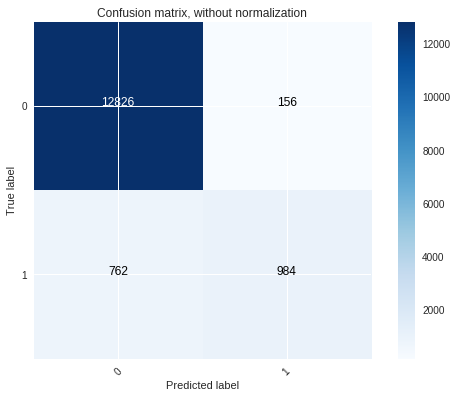

In [31]:
cnf_matrix = confusion_matrix((dprice_1>0).astype(np.int), (dp_predict_early>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [32]:
dp_predict_late = clf.predict(s_20)

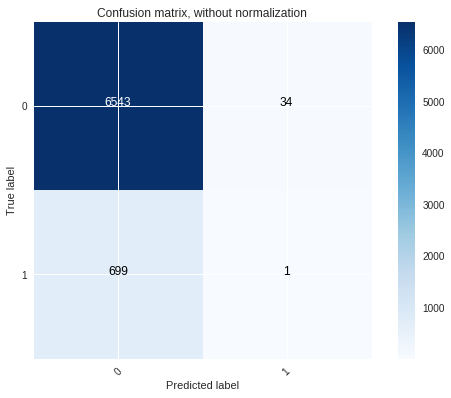

In [33]:
cnf_matrix = confusion_matrix((dprice_2>0).astype(np.int), (dp_predict_late>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [16]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)

In [17]:
fm.fit(csr_matrix(s_10.values), dprice_1)

FMRegression(init_stdev=0.1, l2_reg=0, l2_reg_V=0.5, l2_reg_w=0.1,
       n_iter=1000, random_state=123, rank=2)

In [18]:
dp_predict = fm.predict(csr_matrix(s_10.values))

In [19]:
dp_predict[:10]

array([-1.69847949, -1.69847949, -1.00957172, -1.69847949, -1.69847949,
       -1.00957172, -1.27719787, -1.50617013, -1.30791479, -2.13560806])

In [20]:
dprice_1[:10]

0    -0.762
1     0.376
2     0.473
5    -0.665
6     0.473
7     0.570
10   -0.003
13   -0.015
14    1.126
16   -1.967
Name: dprice, dtype: float64

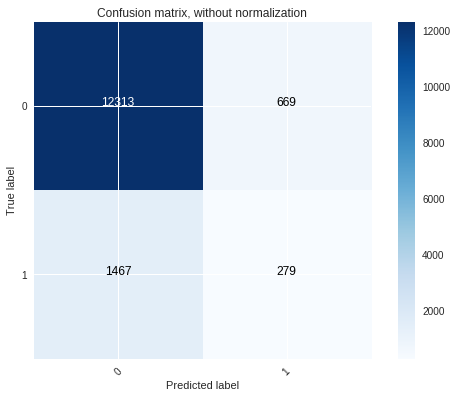

In [21]:
cnf_matrix = confusion_matrix((dprice_1>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()